# **1. Data Process Regression**
---

## **1.1 Library imports**

In [1]:
import pandas as pd
import os
import glob
import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import json
from scipy import stats

c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reproducibility
np.random.seed(42)
random.seed(42)

## **1.2 File imports**

The code is written to first descrive how many files and which files are in the folder (with extension .txt)

In [3]:
# folder for txt files
folder = 'qws1_dataset/*.txt'

# list of files
files = glob.glob(folder)

# number of files
count = 1
for file in files:
    print(f'File number {count} - {file}')
    count += 1

File number 1 - qws1_dataset\qws1.txt


In [4]:
df_list = []

for file in files:
    try:
        # Detect header dynamically
        with open(file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        header_line = None
        for i, line in enumerate(lines):
            if ',' in line:
                header_line = i
                break
        
        if header_line is None:
            print(f"Skipping {file}: No CSV content found")
            continue
        
        # Read from detected header line
        df = pd.read_csv(file, sep=',', skiprows=header_line)
        df_list.append(df)
    
    except Exception as e:
        print(f"Skipping {file}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True, sort=False)
else:
    print("No valid files")

Collect all data from the files and puts them all in 1 DataFrame.

## **1.3 Data Split**

- The data will be split 2 time and into 2 parts each time, using a ratio of 70% and 30%:
    - First split (70% training, 30% remaining).
    - Second split using only the 30% remaining data (70% test, 30% validation exported and used in a future section of the project). 
- According to the previous EDA analysis and correlation matrix, 4 columns will be dropped because it contain information irrelevant or leak into the target variable

In [5]:
# 1. Drop leakage columns
leakage_cols = ['Service Name', 'WSDL Address', 'Latency', 'Best Practices']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

# 2. Validate features
qos_features = ['Response Time', 'Availability', 'Throughput', 'Successability', 'Reliability', 'Compliance', 'Documentation']
missing_features = [col for col in qos_features if col not in df.columns]
if missing_features:
    raise KeyError(f"Missing features: {missing_features}")

X = df[qos_features].copy()

# 3. Validate target
target_col = 'WsRF: Web Service Relevancy Function (%)'
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found.")
y = df[target_col].copy()

# 4. First split: Train (70%) and Remaining (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 5. Split remaining: Test (70%) and Validation (30%)
X_test, X_val, y_test, y_val = train_test_split(
    X_remaining, y_remaining, test_size=0.3, random_state=42
)

# 6. Save validation data
val_data = pd.concat([X_val, y_val], axis=1)
val_data.to_csv('qws1_dataset/validation_data_regression.csv', index=False)

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Validation: {X_val.shape}")

Train: (254, 7), Test: (77, 7), Validation: (33, 7)


---
# **2. Pipeline**
---

Pipeline with three steps:
- Imputer: replaces missing values with the median.
- Scaler: standardizes features (mean=0, std=1).
- Model: fits a Linear Regression model.

In [6]:
def build_pipeline(model, scale=True):
    '''Function to build models.
    As the arguments, chose the type of model and define scalling as True or False
    
    # Example usage:

    pipeline = build_pipeline(LinearRegression(), scale=True)
    pipeline.fit(X_train, y_train)'''

    steps = [('imputer', SimpleImputer(strategy='median'))]
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))
    return Pipeline(steps=steps)

## **2.1 Baseline Model**

- This is the baseline evaluation, setting a reference point for future models. Any model trained should aim for an RMSE lower than 13.41 to be better than the baseline.
- This next code block is computing manually the baseline model, while the next code block is the standard way according to scikit-learn

In [7]:
# Baseline prediction: mean of training target
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

# Compute metrics
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"Baseline RMSE: {baseline_rmse:.2f}, MAE: {baseline_mae:.2f}, Baseline R²: {baseline_r2:.2f}")

Baseline RMSE: 14.11, MAE: 11.16, Baseline R²: -0.01


In [8]:
# Standard way to create Dummy model that predicts the mean of y_train
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)

# Predict on test data
dummy_pred = dummy_reg.predict(X_test)

# Metrics
dummy_rmse = root_mean_squared_error(y_test, dummy_pred)
dummy_mae = mean_absolute_error(y_test, dummy_pred)
dummy_r2 = r2_score(y_test, dummy_pred)

print(f"DummyRegressor Baseline -> RMSE: {dummy_rmse:.2f}, MAE: {dummy_mae:.2f}, R²: {dummy_r2:.2f}")

DummyRegressor Baseline -> RMSE: 14.11, MAE: 11.16, R²: -0.01


## **2.2 Model Definition**

In [9]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}
preds = {}

for name, model in models.items():
    # Scale only for Linear Regression
    scale = True if name == 'Linear Regression' else False
    pipeline = build_pipeline(model, scale=scale)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Store metrics
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    
    # Store predictions
    preds[name] = y_pred

# Add baseline predictions
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
preds['Baseline'] = baseline_pred

# DataFrame with actual and predicted
preds_df_untuned = pd.DataFrame({'Actual Values': y_test})
for model_name, y_pred in preds.items():
    preds_df_untuned[model_name] = y_pred

print("\nPredictions vs Actual:")
preds_df_untuned.head()


Predictions vs Actual:


,Actual Values,Linear Regression,Random Forest,XGBoost,Baseline
351,44,45.824753,50.37,49.866547,66.779528
336,51,55.919658,56.53,57.707050,66.779528
82,75,73.636442,74.52,76.257835,66.779528
362,32,35.214237,44.69,42.634846,66.779528
316,54,55.723713,54.26,52.747818,66.779528


In [10]:
for name, model in models.items():
    pipeline = build_pipeline(model, scale=(name == 'Linear Regression'))
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name} CV RMSE: {-scores.mean():.2f} ± {scores.std():.2f}")

Linear Regression CV RMSE: 2.82 ± 0.34
Random Forest CV RMSE: 3.23 ± 0.49
XGBoost CV RMSE: 3.29 ± 0.54


## **2.3 Model Evalution**

In order to evaluate these models there will be used 3 measures:
 - Root Mean Squared Error (RMSE): Square root of MSE. Same units as the target.
 - Mean absolute Error (MAE): Average of absolute differences between predictions and actual values.
 - ($R^2$): Measures how much variance in the target is explained by the model.

In [11]:
# Display results
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, R²={metrics['R²']:.3f}")

# Convert to DataFrame
results['Baseline'] = {'RMSE': baseline_rmse, 'MAE': baseline_mae, 'R²': baseline_r2}
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Model', 'RMSE', 'MAE', 'R²']
print("\nModel Performance:")
results_df

Linear Regression: RMSE=3.71, MAE=2.62, R²=0.930
Random Forest: RMSE=4.46, MAE=2.96, R²=0.899
XGBoost: RMSE=3.96, MAE=2.74, R²=0.921

Model Performance:


,Model,RMSE,MAE,R²
0,Linear Regression,3.711444,2.617011,0.930104
1,Random Forest,4.460393,2.962208,0.899049
2,XGBoost,3.956391,2.739067,0.920574
3,Baseline,14.113575,11.164434,-0.010740


| Model | RMSE | MAE | $R^{2}$ |
|--- | --- | --- | --- |
| Linear Regression | 3.7114442163022945 | 2.617011135723248 | 0.9301041733912487 |
| Random Forest | 4.460393232912071 | 2.962207792207793 | 0.8990487578585941 |
| XGBoost | 3.9563910961151123 | 2.7390668392181396 | 0.9205737709999084 |
| Baseline | 14.113574994991348 | 11.164433991205646 | -0.010739971806268622 |

Insights:
- RMSE and MAE lower than baseline RMSE (13.4).
- Models are adding significant predictive value compared to a naive mean predictor.
- Linear Regression has the lowest RMSE (3.599) and highest R² (0.928).
- All models have R² > 0.91, meaning they explain over 91% of the variance in the target.
- This indicates strong predictive power and good feature relevance.

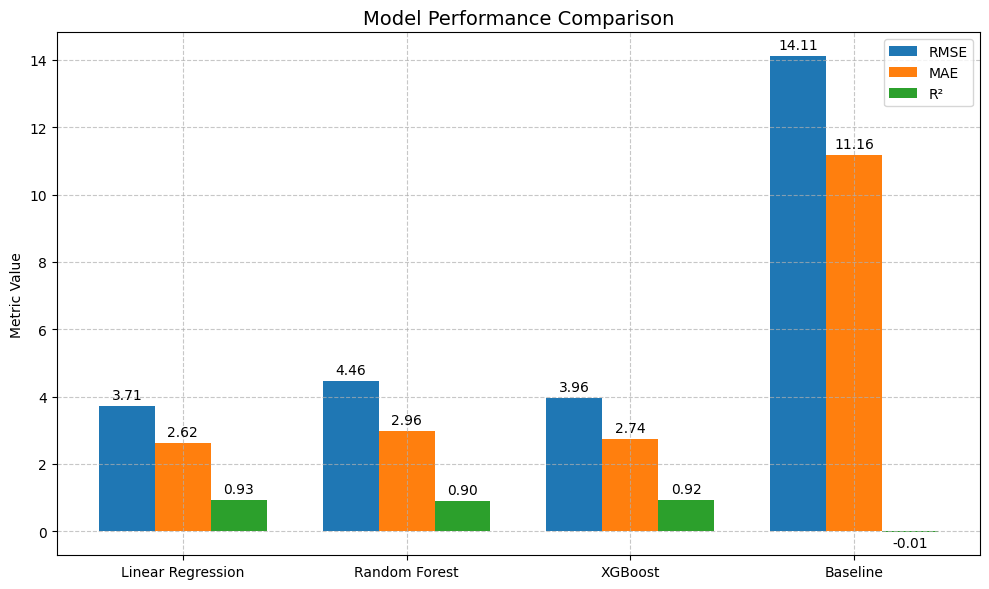

In [12]:
metrics = ['RMSE', 'MAE', 'R²']
x = np.arange(len(results_df['Model']))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

bars = [] 
for i, metric in enumerate(metrics):
    bar_container = ax.bar(x + i*width, results_df[metric], width, label=metric)
    bars.append(bar_container)

for bar_container in bars:
    ax.bar_label(bar_container, fmt='%.2f', padding=3)

ax.set_xticks(x + width)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xticklabels(results_df['Model'])
ax.set_ylabel('Metric Value')
ax.set_title('Model Performance Comparison', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

#### 2.3.1 Bootstrapping to calculate a confidence interval (CI):

In [13]:
def bootstrap_ci(metric_func, y_true, y_pred, n_bootstrap=1000):
    metrics = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))
    return np.percentile(metrics, [2.5, 97.5])

# Compute CI for each model
for name, y_pred in preds.items():
    rmse_ci = bootstrap_ci(root_mean_squared_error, y_test.values, y_pred)
    mae_ci = bootstrap_ci(mean_absolute_error, y_test.values, y_pred)
    r2_ci = bootstrap_ci(r2_score, y_test.values, y_pred)
    print(f"{name} -> RMSE 95% CI: {rmse_ci}, MAE 95% CI: {mae_ci}, R² 95% CI: {r2_ci}")

Linear Regression -> RMSE 95% CI: [2.74341506 4.58468163], MAE 95% CI: [2.08743929 3.26100285], R² 95% CI: [0.88649726 0.96065386]
Random Forest -> RMSE 95% CI: [3.41797974 5.53823771], MAE 95% CI: [2.23080195 3.71299675], R² 95% CI: [0.86527927 0.92839987]
XGBoost -> RMSE 95% CI: [2.98148444 5.05028574], MAE 95% CI: [2.12715898 3.44716098], R² 95% CI: [0.88176479 0.94942352]
Baseline -> RMSE 95% CI: [12.05795723 16.16762716], MAE 95% CI: [ 9.336742   13.27902137], R² 95% CI: [-1.05991093e-01 -3.87852403e-05]


A confidence interval gives a range of values that likely contains the true metric for the model, based on testing data.

Bootstrapping simulates many possible test sets by resampling testing data.

The CI shows the uncertainty. The following example applies for RMSE for explainability:
- Baseline RMSE 95% CI: [12.06, 16.17] means: If repeated this experiment, 95% of the time the RMSE would fall between 12.06 and 16.17.

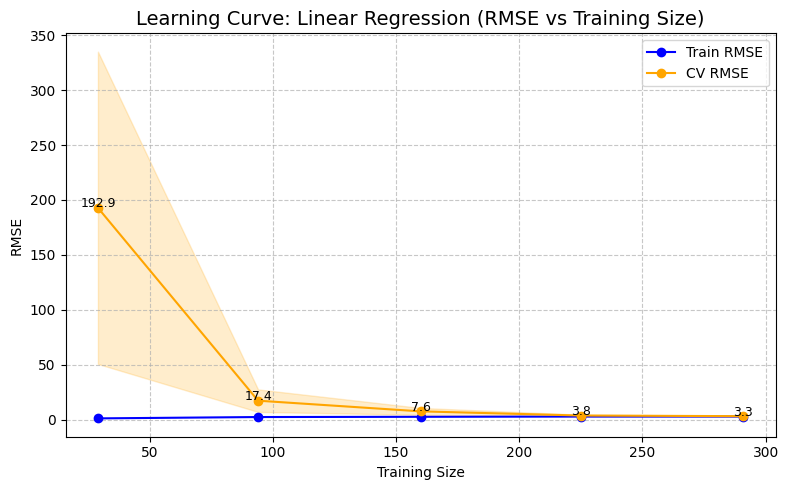

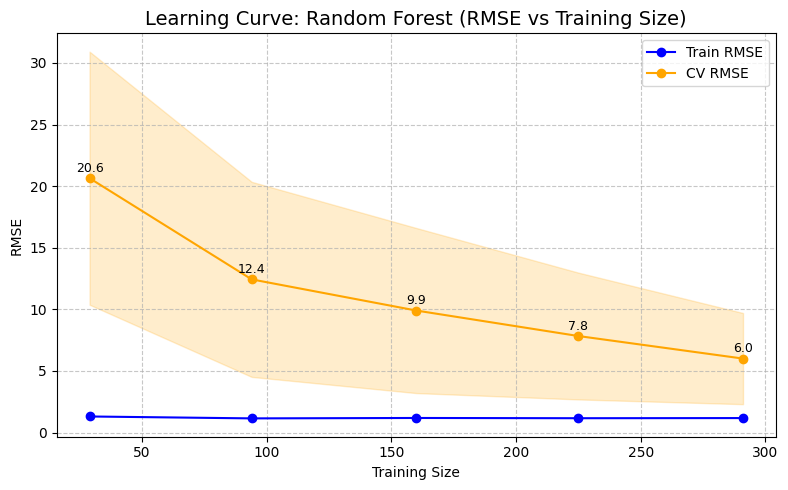

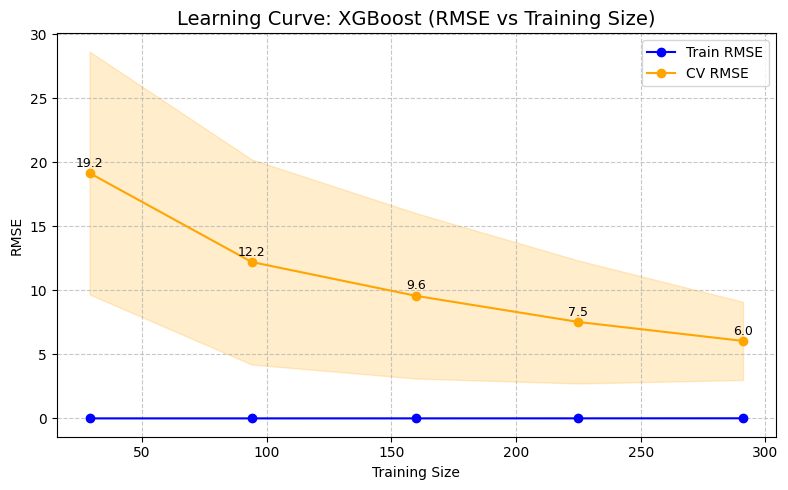

In [14]:
# Learning curves for all models
for name, model in models.items():
    # Rebuild pipeline for each model
    pipeline = build_pipeline(model, scale=(name == 'Linear Regression'))

    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, -train_scores.mean(axis=1), 'o-', color='blue', label='Train RMSE')
    plt.plot(train_sizes, -test_scores.mean(axis=1), 'o-', color='orange', label='CV RMSE')

    # Shaded area for variability
    plt.fill_between(train_sizes,
                     -test_scores.mean(axis=1) - test_scores.std(axis=1),
                     -test_scores.mean(axis=1) + test_scores.std(axis=1),
                     alpha=0.2, color='orange')

    # Grid and labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f'Learning Curve: {name} (RMSE vs Training Size)', fontsize=14)
    plt.xlabel('Training Size')
    plt.ylabel('RMSE')

    # Annotate CV RMSE values
    for x, y_val in zip(train_sizes, -test_scores.mean(axis=1)):
        plt.text(x, y_val + 0.5, f"{y_val:.1f}", ha='center', fontsize=9)

    plt.legend()
    plt.tight_layout()
    plt.show()

1. Linear Regression (benefits greatly from more data, overfitting is evident at small sample sizes)
    - Train RMSE (blue): Starts near zero and stays extremely low across all training sizes.
    - The model fits training data almost perfectly, which is expected for linear regression on small datasets.
    - CV RMSE (orange): Starts very high (~192.9) with small training size, then drops sharply to ~3.3 at full size.
    - Gap between train and CV RMSE at small sizes -> severe overfitting initially.
    - Trend: As training size increases, CV RMSE decreases and stabilizes but never meets train RMSE

2. Random Forest (highly flexible and overfits small datasets, dding data improves CV RMSE but gap persists)
    - Train RMSE (blue): Very low (~1.5) and flat across all sizes -> model memorizes training data.
    - CV RMSE (orange): Starts at ~20.6, decreases gradually to ~6.0 at full size.
    - Shaded region: Wide at small sizes, narrows as size grows -> variance reduces with more data.

3. XGBoost (Overfits small datasets, Still needs regularization or more data to close the gap)
    - Train RMSE (blue): Near zero across all sizes -> extreme memorization.
    - CV RMSE (orange): Starts at ~19.2, drops to ~6.0, overfitting similar to Random Forest but better CV RMSE at mid-range sizes.
    - Variance: High at small sizes, narrows with more data.

---
# **3. Tuning - RandomizedSearchCV**
---

Hyperparameters. Example for Linear Regression:
- fit_intercept: Whether to calculate the intercept (True/False).
- positive: Force coefficients to be positive (True/False).
- normalize: Deprecated in newer versions (use StandardScaler instead).
- n_jobs: For parallel computation (usually not critical here).

## **3.1 Linear Regression**

In [15]:
# Parameter grid
param_grid_lr = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

# Pipeline with scaling
lr_pipeline = build_pipeline(LinearRegression(), scale=True)

# RandomizedSearchCV
lr_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid_lr,
    n_iter=4, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

lr_search.fit(X_train, y_train)

print("Best Params:", lr_search.best_params_)
print("Best CV RMSE:", -lr_search.best_score_)

Best Params: {'model__positive': False, 'model__fit_intercept': True}
Best CV RMSE: 2.823827438941742


## **3.2 Random Forest**

In [16]:
# Parameter grid
param_grid_rf = {
    'model__n_estimators': randint(50, 300),
    'model__max_depth': randint(3, 20),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

# Pipeline (no scaling)
rf_pipeline = build_pipeline(RandomForestRegressor(random_state=42), scale=False)

# RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Best Params:", rf_search.best_params_)
print("Best CV RMSE:", -rf_search.best_score_)

Best Params: {'model__max_depth': 14, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 268}
Best CV RMSE: 3.215807948241376


## **3.3 XGBoost**

In [17]:
# Parameter grid
param_grid_xgb = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0]
}

# Pipeline (no scaling)
xgb_pipeline = build_pipeline(XGBRegressor(random_state=42), scale=False)

# RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("Best Params:", xgb_search.best_params_)
print("Best CV RMSE:", -xgb_search.best_score_)

Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 291, 'model__subsample': 0.6}
Best CV RMSE: 2.3546348571777345


Linear Regression:
1. Tests combinations of fit_intercept and positive using RandomizedSearchCV with 5-fold CV.
2. Finds the best configuration based on lowest RMSE.

Random Forest:
1. Randomly samples values for n_estimators, max_depth, min_samples_split, and min_samples_leaf.
2. Runs 20 iterations with 5-fold CV.
3. Returns best parameters and best cross-validated RMSE.

XGBoost:
1. Samples n_estimators, max_depth, learning_rate, and subsample.
2. Also uses 20 iterations and 5-fold CV.
3. Returns best parameters and best CV RMSE.

---
# **4. Prediction**
---

In [18]:
best_lr = lr_search.best_estimator_
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Predict and evaluate
for name, model in [('Linear Regression', best_lr), ('Random Forest', best_rf), ('XGBoost', best_xgb)]:
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

Linear Regression: RMSE=3.71, MAE=2.62, R²=0.930
Random Forest: RMSE=4.59, MAE=3.08, R²=0.893
XGBoost: RMSE=3.31, MAE=2.30, R²=0.944


1. Extract best models
2. Evaluate tuned models on test set

## **4.1 Comparison**

In [19]:
# Baseline
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

previous_results = results_df.copy()
previous_results['Model'] = previous_results['Model'] + ' (Untuned)'


# Remove any accidental Baseline (Untuned)
previous_results = previous_results[previous_results['Model'] != 'Baseline (Untuned)']

# Tuned Results
tuned_data = []
tuned_preds = {}
for name, model in [('Linear Regression', best_lr), ('Random Forest', best_rf), ('XGBoost', best_xgb)]:
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    tuned_data.append({'Model': f'{name} (Tuned)', 'RMSE': rmse, 'MAE': mae, 'R²': r2})
    tuned_preds[name] = y_pred

tuned_results = pd.DataFrame(tuned_data)

# Baseline Row
baseline_row = pd.DataFrame([{'Model': 'Baseline', 'RMSE': baseline_rmse, 'MAE': baseline_mae, 'R²': baseline_r2}])

# Combine All
comparison_df = pd.concat([baseline_row, previous_results, tuned_results], ignore_index=True)

print("\nComparison Table:")
comparison_df


Comparison Table:


,Model,RMSE,MAE,R²
0,Baseline,14.113575,11.164434,-0.010740
1,Linear Regression (Untuned),3.711444,2.617011,0.930104
2,Random Forest (Untuned),4.460393,2.962208,0.899049
3,XGBoost (Untuned),3.956391,2.739067,0.920574
4,Linear Regression (Tuned),3.711444,2.617011,0.930104
5,Random Forest (Tuned),4.593172,3.080665,0.892949
6,XGBoost (Tuned),3.310229,2.300055,0.944399


In [20]:
# Predictions DataFrame
preds_df_tuned = pd.DataFrame({'Actual Values': y_test})
for model_name, y_pred in tuned_preds.items():
    preds_df_tuned[model_name] = y_pred
preds_df_tuned['Baseline'] = baseline_pred

print("\nActual vs Predictions:")
preds_df_tuned.head()


Actual vs Predictions:


,Actual Values,Linear Regression,Random Forest,XGBoost,Baseline
351,44,45.824753,51.000000,48.863457,66.779528
336,51,55.919658,56.910448,54.868435,66.779528
82,75,73.636442,74.447761,74.615623,66.779528
362,32,35.214237,44.671642,41.331425,66.779528
316,54,55.723713,54.332090,53.654556,66.779528


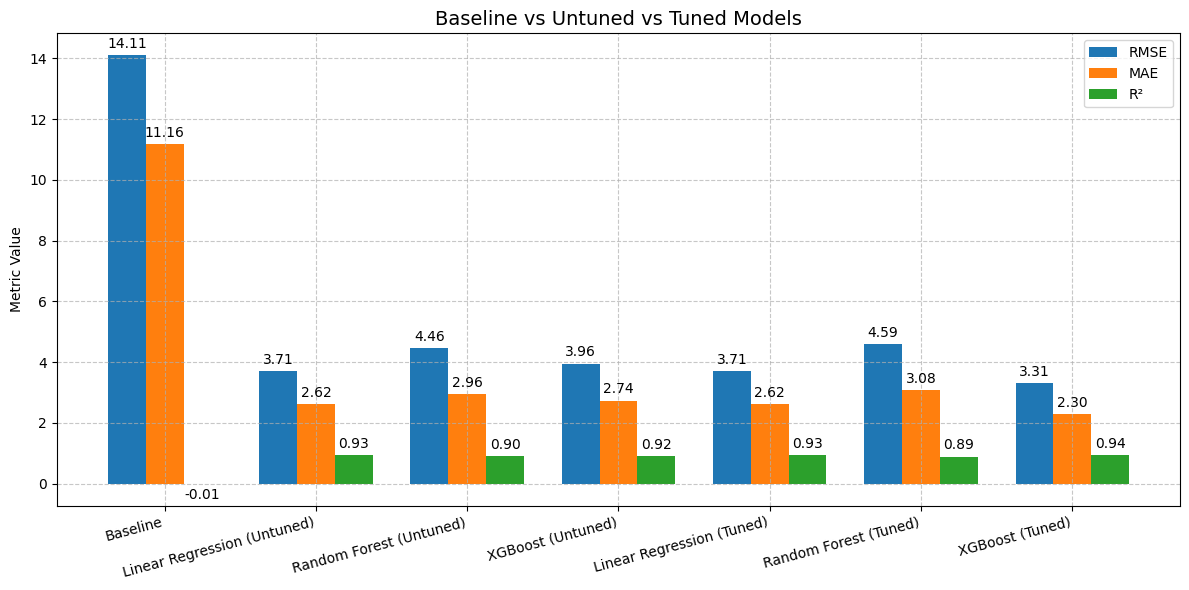

In [21]:
# Remove "Baseline (Untuned)" from the DataFrame
plot_df = comparison_df[comparison_df['Model'] != 'Baseline (Untuned)']

# Plot
metrics = ['RMSE', 'MAE', 'R²']
x = np.arange(len(plot_df['Model']))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars = []
for i, metric in enumerate(metrics):
    bar_container = ax.bar(x + i*width, plot_df[metric], width, label=metric)
    bars.append(bar_container)

# Add labels
for bar_container in bars:
    ax.bar_label(bar_container, fmt='%.2f', padding=3)

ax.set_xticks(x + width)
ax.set_xticklabels(plot_df['Model'], rotation=15, ha='right')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_ylabel('Metric Value')
ax.set_title('Baseline vs Untuned vs Tuned Models', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

## **4.2 Residual Analysis**

This analysis will be done for the best model (XGBoost)

Residual Summary:
Mean Residual: -0.56
Std Residual: 3.26
Min Residual: -9.33
Max Residual: 14.38


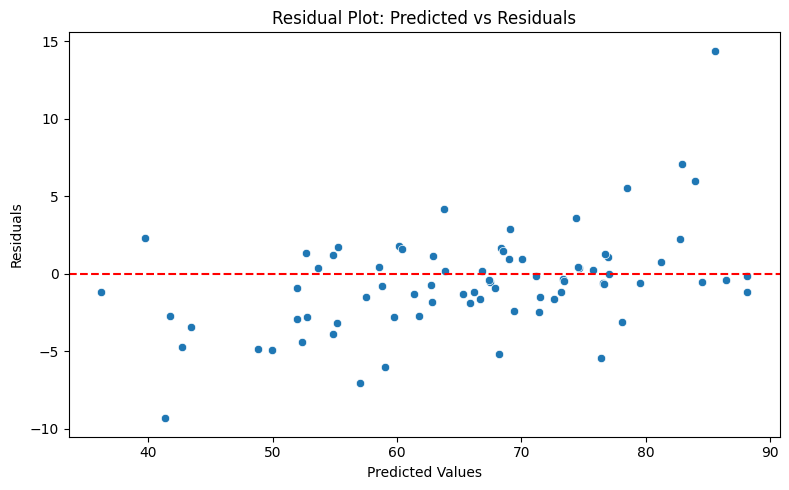

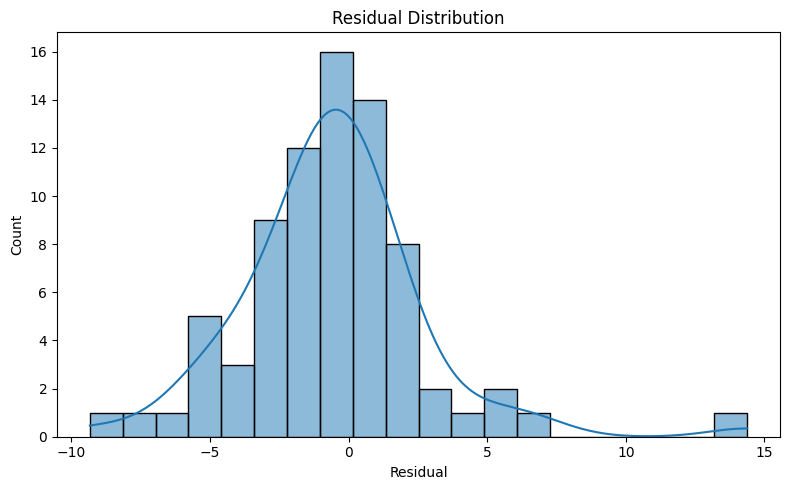

In [22]:
# Compute residuals
y_pred = best_xgb.predict(X_test)
residuals = y_test - y_pred

# Numeric summary
print("Residual Summary:")
print(f"Mean Residual: {np.mean(residuals):.2f}")
print(f"Std Residual: {np.std(residuals):.2f}")
print(f"Min Residual: {np.min(residuals):.2f}")
print(f"Max Residual: {np.max(residuals):.2f}")

# Scatter plot: Predicted vs Residuals
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot: Predicted vs Residuals")
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

For the Residual Plot (Predicted vs Residuals):
- Centering around zero: Most residuals cluster near the red line (0), which is good — predictions are generally unbiased.
- Spread increases slightly for higher predicted values: At predicted values above ~75, residuals become more positive and more variable.
- This suggests mild heteroscedasticity (variance of errors grows with predicted value).
- Outliers: There are a few large positive residuals (up to ~15), meaning the model underpredicted those cases significantly.

Residual Distribution (Histogram):
- Shape: Mostly bell-shaped and centered near zero, which is ideal for regression assumptions.
- Slight right skew: A tail toward positive residuals indicates some cases where the model underestimates the target.
- No severe multimodality: No clear clusters, so the model likely captures the main pattern well.

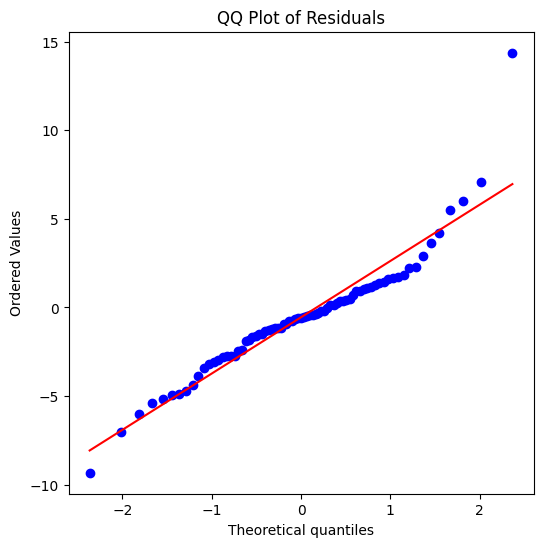

In [23]:
# QQ Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

Central Alignment
- Most points lie close to the red diagonal line in the middle range (around theoretical quantiles from -1 to +1).
- This indicates that residuals are approximately normally distributed for the bulk of the data.

Heavy Right Tail (Positive Outliers)
- The top-right points deviate strongly from the line, especially two extreme points:
    - One near 9
    - Another near 15
- These represent large positive residuals, meaning the model underpredicted these observations significantly.
- This is expected when the dataset is small and outliers are retained.

Slight Left Tail Deviation
- Bottom-left points also deviate from the line, with the most extreme around -10.
- Indicates some negative residuals (model overpredicted these observations), but these are less severe than the positive outliers.

---
# **5. Feature Importance**
---

In [24]:
# Linear Regression coefficients
lr_importance = pd.Series(best_lr.named_steps['model'].coef_, index=X_train.columns)
lr_rank = lr_importance.abs().rank(ascending=False)

# Random Forest feature importance
rf_estimator = best_rf.named_steps['model'] if hasattr(best_rf, 'named_steps') else best_rf
rf_importance = pd.Series(rf_estimator.feature_importances_, index=X_train.columns)
rf_rank = rf_importance.rank(ascending=False)

# XGBoost feature importance
xgb_estimator = best_xgb.named_steps['model'] if hasattr(best_xgb, 'named_steps') else best_xgb
xgb_importance = pd.Series(xgb_estimator.feature_importances_, index=X_train.columns)
xgb_rank = xgb_importance.rank(ascending=False)

# Combined DataFrame
ranking_df = pd.DataFrame({
    'Linear Regression Importance': lr_importance,
    'Linear Regression Rank': lr_rank,
    'Random Forest Importance': rf_importance,
    'Random Forest Rank': rf_rank,
    'XGBoost Importance': xgb_importance,
    'XGBoost Rank': xgb_rank
}).sort_values('Linear Regression Rank') 

ranking_df


,Linear Regression Importance,Linear Regression Rank,Random Forest Importance,Random Forest Rank,XGBoost Importance,XGBoost Rank
Reliability,5.484326,1.0,0.202936,1.0,0.175877,2.0
Documentation,4.817228,2.0,0.127607,6.0,0.128511,5.0
Successability,3.487387,3.0,0.191735,2.0,0.229141,1.0
Throughput,3.067676,4.0,0.150196,4.0,0.152113,4.0
Availability,1.357923,5.0,0.137640,5.0,0.165258,3.0
Response Time,-0.905274,6.0,0.180282,3.0,0.120262,6.0
Compliance,0.448408,7.0,0.009604,7.0,0.028838,7.0


Insights:
- Across models, Successability, Availability, Reliability consistently rank high → critical for predicting relevancy.
- Compliance is consistently low → likely not informative.
- Differences between Random Forest and XGBoost suggest model-specific feature weighting (tree depth and boosting effects).

## **5.1 SHAP Interpretation**

- Positive SHAP value → pushes prediction up.
- Negative SHAP value → pushes prediction down.

C:\Users\riabreu\AppData\Local\Temp\ipykernel_16528\3245236794.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


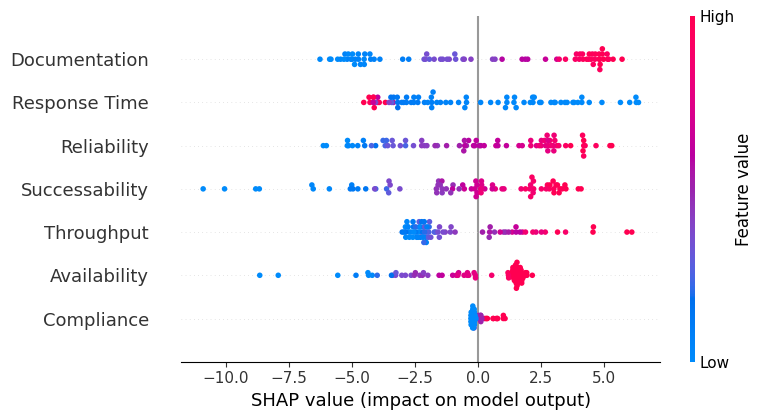

In [25]:
# Model inside pipeline
model = best_xgb.named_steps['model']

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

Top features:
- Documentation, Response Time, Reliability, Successability have the largest spread → most influential.

Direction of impact:
- For Response Time: High values (red) tend to push predictions down (negative SHAP), meaning slower response reduces relevancy.
- For Availability: High values (red) push predictions up, meaning better availability increases relevancy.
- Compliance: Very small SHAP range → minimal effect on predictions.
- Symmetry: Most features have both positive and negative SHAP values → model captures complex interactions.

C:\Users\riabreu\AppData\Local\Temp\ipykernel_16528\1433923088.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_abs_shap', y='feature', data=top_features, palette='viridis')


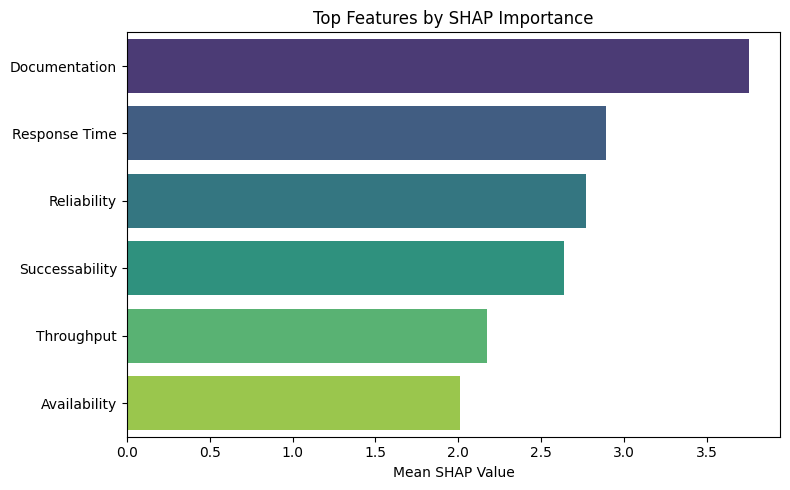

In [26]:
# Mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

# Top 6 features
top_features = shap_importance.head(6)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='mean_abs_shap', y='feature', data=top_features, palette='viridis')
plt.title('Top Features by SHAP Importance')
plt.xlabel('Mean SHAP Value')
plt.ylabel('')
plt.tight_layout()
plt.show()

---
# **6. Export Metrics**
---

## 6.1 Save Model + Preprocessor

In [27]:
joblib.dump(best_xgb, "models/regression/best_xgb_pipeline.pkl")
joblib.dump(best_lr, "models/regression/best_lr_pipeline.pkl")
joblib.dump(best_rf, "models/regression/best_rf_pipeline.pkl")

print("Models saved successfully!")

Models saved successfully!


Afterwads, the model can be loaded with `model = joblib.load("models/regression/best_xgb_pipeline.pkl`

In [28]:
# Evaluate and saved metrics for each model
for name, model in [("LinearRegression", best_lr),
                    ("RandomForest", best_rf),
                    ("XGBoost", best_xgb)]:
    y_pred = model.predict(X_test)
    metrics = {
        "RMSE": float(root_mean_squared_error(y_test, y_pred)),
        "MAE": float(mean_absolute_error(y_test, y_pred)),
        "R2": float(r2_score(y_test, y_pred))
    }

    # File paths
    json_path = f"models/regression/{name}_metrics.json"
    csv_path = f"models/regression/{name}_metrics.csv"

    # If file exists, overwrite (default behavior)
    # If skip overwriting, check first:
    if not os.path.exists(json_path):
        with open(json_path, "w") as f:
            json.dump(metrics, f, indent=4)
    else:
        print(f"File {json_path} already exists. Skipping...")

    if not os.path.exists(csv_path):
        pd.DataFrame([metrics]).to_csv(csv_path, index=False)
    else:
        print(f"File {csv_path} already exists. Skipping...")

print("Metrics saved for all models!")


File models/regression/LinearRegression_metrics.json already exists. Skipping...
File models/regression/LinearRegression_metrics.csv already exists. Skipping...
File models/regression/RandomForest_metrics.json already exists. Skipping...
File models/regression/RandomForest_metrics.csv already exists. Skipping...
File models/regression/XGBoost_metrics.json already exists. Skipping...
File models/regression/XGBoost_metrics.csv already exists. Skipping...
Metrics saved for all models!


## 6.2 Model Card

Markdown file summarizing the model

In [29]:

# tuned_results contains columns: Model, RMSE, MAE, R²
model_card = f"""
# Model Card: Regression Models Comparison
**Version:** v1.0  
**Date:** 2025-11-24  
**Owner:** Data & AI Academy  

## Data
- **Source:** QWS dataset ver 1.0
- **Features:** Response Time, Availability, Throughput, Successability, Reliability, Compliance, Documentation
- **Target:** WsRF: Web Service Relevancy Function (%)
- **Train/Test Split:** 70/30

## Models and Performance
| Model             | RMSE   | MAE    | R²    |
|-------------------|--------|--------|-------|
"""

for _, row in tuned_results.iterrows():
    model_card += f"| {row['Model']} | {row['RMSE']:.2f} | {row['MAE']:.2f} | {row['R²']:.3f} |\n"

model_card += """
## Files
- **Models:** best_lr_pipeline.pkl, best_rf_pipeline.pkl, best_xgb_pipeline.pkl
- **Metrics:** Separate JSON/CSV files for each model

## Limitations
- Assumes QoS metrics are stable; may underperform on unseen service types.

## Intended Use
- Predict Web Service Relevancy for ranking and selection.

## Ethical Considerations
- Ensure predictions are not used for discriminatory service filtering.
"""

# Save the combined model card
with open("models/regression/model_card_all_models.md", "w") as f:
    f.write(model_card)

print("Combined model card created successfully!")

Combined model card created successfully!
